Below the use of a class tailored for cross-validating logistic regression, RF and XGBoost classifiers will be demonstrated on the two differing datasets obtained in the repository's data prep section.

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [28]:
# Importing the dataset where some of the features were dropped based on t-test results
train_path='/home/RDC/anasashb/Dokumente/brent_price_forecasting/data_prep_and_selection/train_small.pkl' 
test_path='/home/RDC/anasashb/Dokumente/brent_price_forecasting/data_prep_and_selection/test_small.pkl'

with open(train_path, 'rb') as f:
    train = pickle.load(f)

with open(test_path, 'rb') as f:
    test = pickle.load(f)

In [31]:
# Generate sets for predictors and targets
X_train = train.drop('BAD', axis=1)
y_train = train['BAD']
X_test = test.drop('BAD', axis=1)
y_test = test['BAD']

print(f'Train set shapes - X: {X_train.shape}, y: {y_train.shape}\nTest set shapes - X: {X_test.shape}, y: {y_test.shape}')

Train set shapes - X: (980, 12), y: (980,)
Test set shapes - X: (245, 12), y: (245,)


In [59]:
# Importing the dataset without excluded features
train_large_path='/home/RDC/anasashb/Dokumente/brent_price_forecasting/data_prep_and_selection/train.pkl' 
test_large_path='/home/RDC/anasashb/Dokumente/brent_price_forecasting/data_prep_and_selection/test.pkl'

with open(train_large_path, 'rb') as f:
    train_large = pickle.load(f)

with open(test_large_path, 'rb') as f:
    test_large = pickle.load(f)

In [64]:
# Generate sets for predictors and targets
X_train_large = train_large.drop('BAD', axis=1)
y_train_large = train_large['BAD']
X_test_large = test_large.drop('BAD', axis=1)
y_test_large = test_large['BAD']

print(f'Train set shapes - X: {X_train_large.shape}, y: {y_train_large.shape}\nTest set shapes - X: {X_test_large.shape}, y: {y_test_large.shape}')

Train set shapes - X: (980, 18), y: (980,)
Test set shapes - X: (245, 18), y: (245,)


### **Model Validation Class**

The validation class includes methods to 5-fold cross validate Logistic regression, Random Forest and XGBoost classifiers. Besides, grid search methods are included for RF and XGB. 

In [50]:
# Here we begin defining the class
# Cross-validation will be included in all models

class ModelValidator:
    '''
    A custom class to wrap up model k-fold validation functionalities.
    '''

    # Defining initial arguments
    def __init__(self, X, y):
        # Defining initial class inputs as self arguments
        self.X = X
        self.y = y

    def Logit_validate(self):
        '''
        Fits a Logistic regression model given predictors and a target. 
        
        Args:
            alpha: The L2 penalty value - also called lambda for Ridge Regression.
            tuning: Boolean argument. If set to True, a grid search will be carried out for alpha values
                between 0.01 and 1 with step size of 0.01. 
                Note that setting to 0 (linear regression without any penalties ) will cause model to break down.
        Returns:
            logit_scores: An array of 15 ROC-AUC scores obtained from fitting the five folds three times. 
        '''

        # Define cross validation method
        # Use five fold
        cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 66)
        # Set up model
        model = LogisticRegression()

        # To avoid scaling dummy variables
        non_binary = [col for col in self.X.columns if self.X[col].nunique()>2]
        scaler = ColumnTransformer(
            transformers=[
                ('scale', StandardScaler(), non_binary)
                ],
                remainder='passthrough'
                )  

        # Using make_pipeline for our purposes should ensure there is no data leakage 
        # while scaling the folds
        pipeline = make_pipeline(scaler, model)
        
        # ROC-AUC for robust evaluation
        logit_scores = cross_val_score(pipeline, self.X, self.y, scoring = 'roc_auc', cv = cv, n_jobs = -1)

        print('Results:')
        print('-'*100)
        print(f'Logistic Regression ROC-AUC: {np.mean(logit_scores):.4f} | Standard Deviation: {np.std(logit_scores):.4f} |')
        print('='*100)

        return logit_scores
    
    
    def RF_search(self,
                  estimator_range=(50,1001,50),
                  depth_range=(10,51,10)):

        '''
        Simple method to conduct grid search for Random Forest Classifier.
        
        Args:
            estimator_range: (min, max, step) tuple of integers for n_estimators in parameter grid 
            depth_range: (min, max, step) tuple of integers for max_depth in parameter grid 
        Returns:
            best_estimator, best_score
        '''
        # Set up cv
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=66)
        # Set up model 
        model = RandomForestClassifier(random_state=66)
        # Set up grid
        param_grid = {
            'n_estimators': list(range(estimator_range[0], estimator_range[1], estimator_range[2])),
            'max_depth': list(range(depth_range[0], depth_range[1], depth_range[2]))
        }
        # Set up search
        search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
        # Run search
        search.fit(self.X, self.y)
        print('Results:')
        print('-'*100)
        print(f'Best RF ROC-AUC score: {search.best_score_:.4f}')
        print(f'Best Parameters: {search.best_params_}')
        print('='*100)
        
        return search.best_estimator_, search.best_score_

    def RF_validate(self,
                    n_estimators = 100,
                    max_depth = 20,
                    min_samples_split = 2,
                    max_features = 'sqrt'):
        '''
        Fits and cross validates Random Forest classification model given predictors and a target.

        Args:
            n_estimators: How many trees to include in the ensemble (100 by default)
            max_depth: Maximum depth of a tree (20 by default)
            min_samples_split: Minimum amount of samples to split a node (2 by default)
            max_features: Number of features to consider when searching for best split ('sqrt' by default)

        Returns:
            rf_scores: An array of 15 ROC-AUC scores obtained from fitting the five folds three times.

        '''
        # Set up CV
        cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 66)
        model = RandomForestClassifier(n_estimators = n_estimators,
                                      max_depth = max_depth,
                                      min_samples_split = min_samples_split,
                                      max_features = max_features,
                                      random_state = 66
                                      )
        # Same scoring
        rf_scores = cross_val_score(model, self.X, self.y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
        
        print('Results:')
        print('-'*100)
        print(f'RF Classifier ROC-AUC:: {np.mean(rf_scores):.4f} | Standard Deviation: {np.std(rf_scores):.4f} |')
        print('='*100)

        return rf_scores
    

    def XGB_search(self,
                  estimator_range=(50,1001,50),
                  depth_range=(2,11,1),
                  lr_range=[0.01, 0.05, 0.1, 0.3, 0.5]):

        '''
        Simple method to conduct grid search for XGBoost Classifier.
        
        Args:
            estimator_range: (min, max, step) tuple of integers for n_estimators in parameter grid 
            depth_range: (min, max, step) tuple of integers for max_depth in parameter grid
            lr_range: list of floats for learning_rate in param grid 
        Returns:
            best_estimator, best_score
        '''
        # Set up cv
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=66)
        # Set up model 
        model = XGBClassifier(eval_metric='logloss', random_state=66)
        # Set up grid
        param_grid = {
            'n_estimators': list(range(estimator_range[0], estimator_range[1], estimator_range[2])),
            'max_depth': list(range(depth_range[0], depth_range[1], depth_range[2])),
            'learning_rate': lr_range
        }
        # Set up search
        search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
        # Run search
        search.fit(self.X, self.y)
        print('Results:')
        print('-'*100)
        print(f'Best XGB ROC-AUC score: {search.best_score_:.4f}')
        print(f'Best Parameters: {search.best_params_}')
        print('='*100)
        
        return search.best_estimator_, search.best_score_        
    
    def XGB_validate(self,
                    n_estimators = 500,
                    max_depth = 5,
                    learning_rate=0.3):
        '''
        Fits an extreme gradient boosting classification model given predictors and a target.

        Args:
            n_estimators: How many trees to include in the ensemble (500 by default)
            max_depth: Maximum depth of a tree (5 by default)
            learning_rate: Learning rate (0.3 by default)

        Returns:
            xgb_scores: An array of 15 ROC-AUC scores obtained from fitting the five folds three times.

        '''
        # Set up CV
        cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 66)
        # Set up model
        model = XGBClassifier(n_estimators = n_estimators,
                                      max_depth = max_depth,
                                      learning_rate=learning_rate,
                                      random_state = 66
                                      )
        # Same pipeline
        # Same scoring
        xgb_scores = cross_val_score(model, self.X, self.y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
        
        print('Results:')
        print('-'*100)
        print(f'XGB Classifier ROC-AUC: {np.mean(xgb_scores):.4f} | Standard Deviation: {np.std(xgb_scores):.4f} |')
        print('='*100)

        return xgb_scores


### **Validation Runs on Small Dataset**
Below the model validation class is used on train set of the smaller dataset, which had features dropped as per t-test results.

In [54]:
validating_small = ModelValidator(X_train, y_train)

In [55]:
# Cross validate logit on smaller train set
logit_scores_small = validating_small.Logit_validate()

Results:
----------------------------------------------------------------------------------------------------
Logistic Regression ROC-AUC: 0.6593 | Standard Deviation: 0.0294 |


In [56]:
# Grid search RF on smaller train set
validating_small.RF_search()

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Results:
----------------------------------------------------------------------------------------------------
Best RF ROC-AUC score: 0.6250
Best Parameters: {'max_depth': 10, 'n_estimators': 850}


(RandomForestClassifier(max_depth=10, n_estimators=850, random_state=66),
 0.6250285263926861)

In [57]:
rf_scores_small = validating_small.RF_validate(n_estimators=850,
                                           max_depth=10)

Results:
----------------------------------------------------------------------------------------------------
RF Classifier ROC-AUC:: 0.6250 | Standard Deviation: 0.0341 |


In [58]:
validating_small.XGB_search()

Fitting 15 folds for each of 900 candidates, totalling 13500 fits
Results:
----------------------------------------------------------------------------------------------------
Best XGB ROC-AUC score: 0.6492
Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 450}


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.01, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=450, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=66, ...),
 0.6492265117519792)

In [72]:
xgb_scores_small = validating_small.XGB_validate(n_estimators=450, 
                                                 max_depth=2, 
                                                 learning_rate=0.01)

Results:
----------------------------------------------------------------------------------------------------
XGB Classifier ROC-AUC: 0.6492 | Standard Deviation: 0.0329 |


### **Validation Runs on Large Dataset**
Below the model validation class is used on train set of the larger dataset, which had no features dropped.

In [66]:
validating_large = ModelValidator(X_train_large, y_train_large)

In [67]:
# Cross validate logit on larger train set
logit_scores_large = validating_large.Logit_validate()

Results:
----------------------------------------------------------------------------------------------------
Logistic Regression ROC-AUC: 0.6455 | Standard Deviation: 0.0344 |


In [68]:
# Grid search RF on smaller train set
validating_large.RF_search()

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Results:
----------------------------------------------------------------------------------------------------
Best RF ROC-AUC score: 0.6397
Best Parameters: {'max_depth': 10, 'n_estimators': 250}


(RandomForestClassifier(max_depth=10, n_estimators=250, random_state=66),
 0.6396765115672901)

In [69]:
rf_scores_large = validating_large.RF_validate(n_estimators=250,
                                           max_depth=10)

Results:
----------------------------------------------------------------------------------------------------
RF Classifier ROC-AUC:: 0.6397 | Standard Deviation: 0.0428 |


In [70]:
validating_large.XGB_search()

Fitting 15 folds for each of 900 candidates, totalling 13500 fits
Results:
----------------------------------------------------------------------------------------------------
Best XGB ROC-AUC score: 0.6460
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=150, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=66, ...),
 0.6460459339678049)

In [73]:
xgb_scores_large = validating_large.XGB_validate(n_estimators=150,
                                                 max_depth=3,
                                                 learning_rate=0.05)

Results:
----------------------------------------------------------------------------------------------------
XGB Classifier ROC-AUC: 0.6460 | Standard Deviation: 0.0430 |


### **Demo Results**

In [74]:
# Here I generate a data from the scores
scores = [logit_scores_small, logit_scores_large, rf_scores_small, rf_scores_large, xgb_scores_small, xgb_scores_large]
names = ['Logit (small)', 'Logit (large)', 'RF (small)', 'RF (large)', 'XGB (small)', 'XGB (large)']

val_scores = pd.DataFrame(data = np.column_stack(scores), columns = names)
val_scores

,Logit (small),Logit (large),RF (small),RF (large),XGB (small),XGB (large)
0,0.660113,0.659718,0.670009,0.652989,0.641575,0.635968
1,0.721731,0.700884,0.683072,0.687162,0.738884,0.720148
2,0.633868,0.595201,0.640649,0.656755,0.643910,0.640128
3,0.599504,0.576813,0.550078,0.535211,0.587246,0.543492
4,0.685576,0.672209,0.635759,0.697248,0.634194,0.690728
5,0.690790,0.674297,0.641180,0.670867,0.683336,0.655825
6,0.637551,0.612218,0.618815,0.657738,0.633725,0.634384
7,0.633933,0.617110,0.571466,0.620696,0.615936,0.612741
8,0.680099,0.676448,0.650496,0.663537,0.671296,0.682512
9,0.650039,0.627478,0.615219,0.577921,0.648474,0.604004


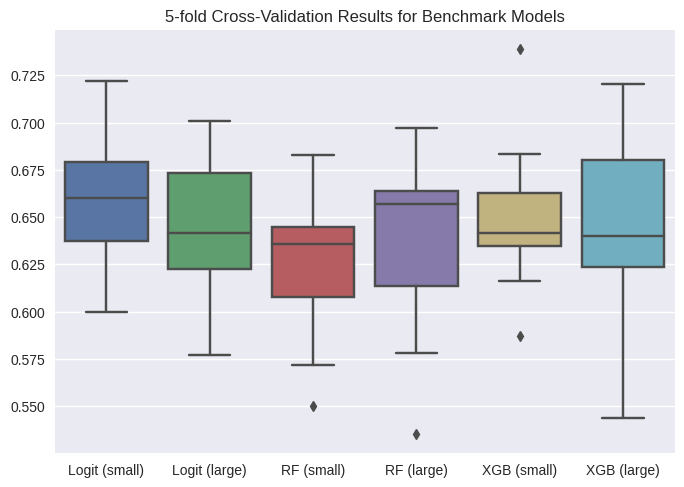

In [75]:
# A bxplot for the results
sns.boxplot(data = val_scores)
plt.title('5-fold Cross-Validation Results for Benchmark Models')
plt.show()
plt.close()

As it should be expected, logistic regression's performance suffers from additional features that were shown to be insignificant based on the t-test. Random Forest performance increases with more data but results have more variance. Meanwhile the XGB classifier had the best ROC-AUC score with the smaller dataset. With more features, the mean ROC-AUC score in the 15 fits decreases while variance rises. Therefore, for further demos the XGB Classifier can be picked with the dataset with less features.  